# Anomalies in meal prices

In the Chamber of Deputies' CEAP, there is a list of 1,000's of meal expenses made by congresspeople. The law says that the congressperson cannot pay for any other, even being her advisor or SO. We want to work on this analysis to find possibly illegal and immoral expenses. They may have happened when the politician spent more than needed (e.g. the whole menu costs X but the bill was 2X) or too much in an specific period of time. In the end, we also want to alert about too expensive reibursements, even with an explanation behind of it.

Note: remember to correct prices with an inflation index (e.g. IPCA).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('../data/2016-11-19-reimbursements.xz',
                      dtype={'applicant_id': np.str,
                             'cnpj_cpf': np.str,
                             'congressperson_id': np.str,
                             'subquota_number': np.str},
                      low_memory=False)
dataset = dataset[dataset['congressperson_id'].notnull()]
dataset['issue_date'] = pd.to_datetime(dataset['issue_date'], errors='coerce')
dataset['issue_date_day'] = dataset['issue_date'].apply(lambda date: date.day)
dataset['issue_date_month'] = dataset['issue_date'].apply(lambda date: date.month)
dataset['issue_date_year'] = dataset['issue_date'].apply(lambda date: date.year)
dataset['issue_date_weekday'] = dataset['issue_date'].apply(lambda date: date.weekday())
dataset['issue_date_week'] = dataset['issue_date'].apply(lambda date: date.week)

In [3]:
is_in_brazil = '(-73.992222 < longitude < -34.7916667) & (-33.742222 < latitude < 5.2722222)'
companies = pd.read_csv('../data/2016-09-03-companies.xz',
                        dtype={'cnpj': np.str},
                        low_memory=False)
companies = companies.query(is_in_brazil)
companies['cnpj'] = companies['cnpj'].str.replace(r'\D', '')
dataset = pd.merge(dataset, companies,
                   how='left',
                   left_on='cnpj_cpf',
                   right_on='cnpj',
                   suffixes=('', '_company'))

In [4]:
dataset = \
    dataset.query('subquota_description == "Congressperson meal"')
companies = \
    companies[companies['cnpj'].isin(dataset.loc[dataset['cnpj'].notnull(),
                                                 'cnpj'])]

In [5]:
dataset['total_net_value'].describe()

count    190763.000000
mean         63.476994
std          75.954606
min           0.010000
25%          24.750000
50%          46.060000
75%          85.000000
max        5880.000000
Name: total_net_value, dtype: float64

In [6]:
dataset['total_net_value'].median()

46.06

In [7]:
bottom_99 = dataset['total_net_value'].quantile(0.99)
bottom_99

244.0

In [8]:
dataset[dataset['total_net_value'] < bottom_99].shape

(188854, 264)

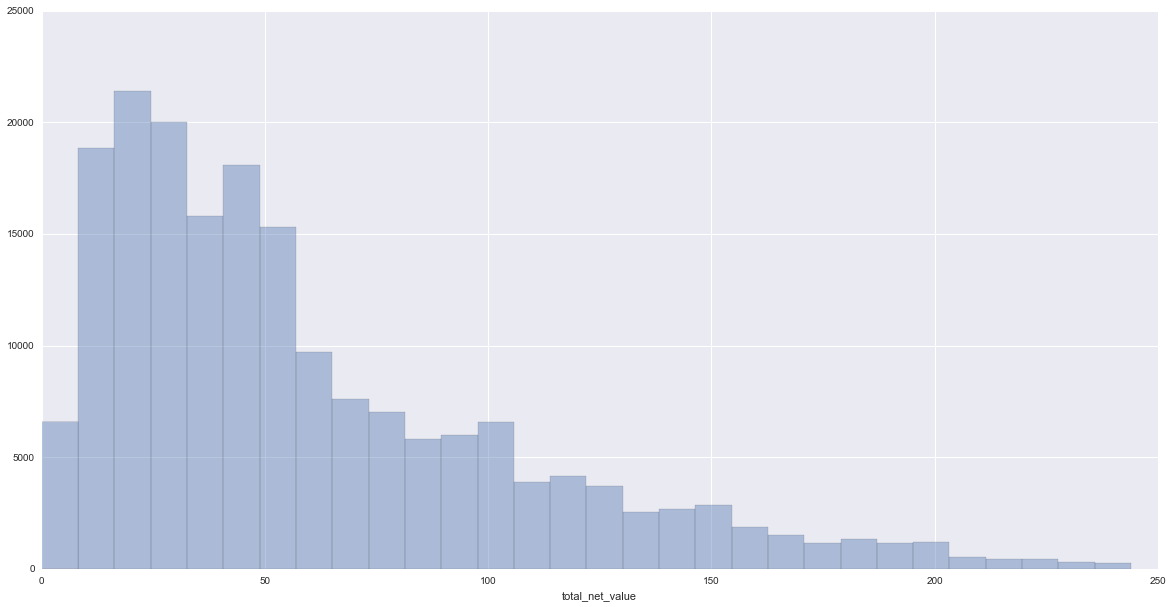

In [9]:
sns.distplot(dataset.loc[dataset['total_net_value'] < bottom_99, 'total_net_value'],
             bins=30,
             kde=False)

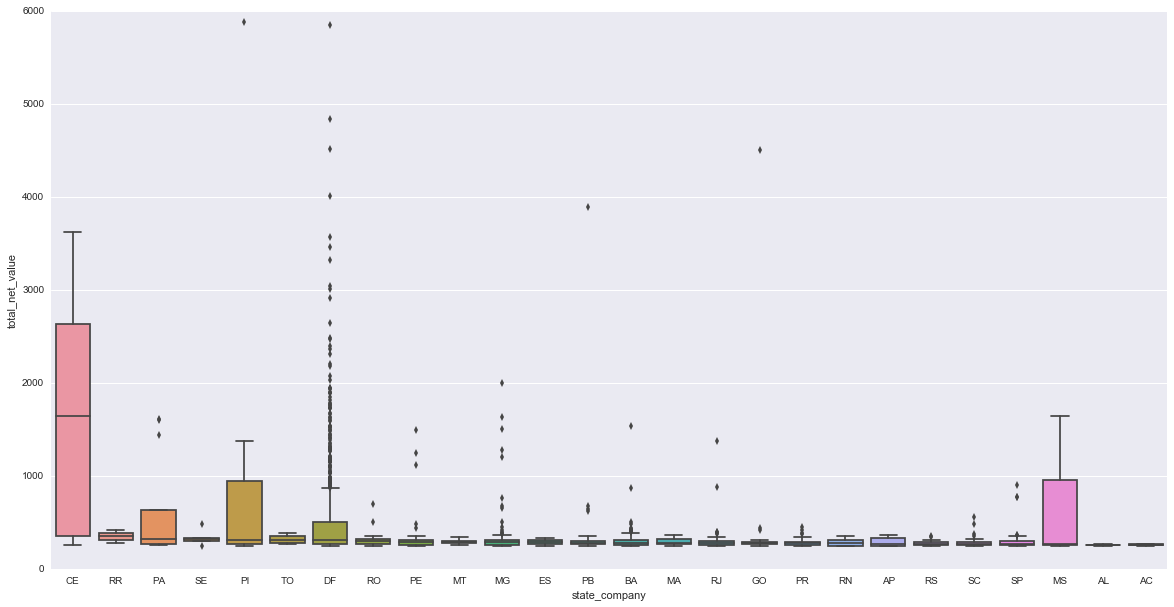

In [10]:
bottom_99_dataset = dataset.query('total_net_value > {}'.format(bottom_99))
ranking = bottom_99_dataset.groupby('state_company')['total_net_value'] \
    .median().sort_values(ascending=False)

sns.boxplot(x='state_company',
            y='total_net_value',
            data=bottom_99_dataset,
            order=ranking.index)

In [11]:
bottom_99_dataset.query('state_company == "CE"').shape

(13, 264)

In [12]:
dataset.query('state_company == "CE"').shape

(1433, 264)

In [13]:
bottom_99_dataset['state_company'].isnull().sum()

216

In [14]:
bottom_99_dataset.query('state_company == "CE"') \
    .sort_values('total_net_value', ascending=False)

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,secondary_activity_97_code,secondary_activity_98,secondary_activity_98_code,secondary_activity_99,secondary_activity_99_code,secondary_activity_9_code,latitude,longitude,latitude.1,longitude.1
23270,2009,1309,1636450,NaN,3623.84,3002,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23291,2009,1309,1681391,NaN,2964.96,3082,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
606742,2012,1309,2427617,NaN,2865.30,4096,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23284,2009,1309,1659987,NaN,2635.52,3046,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803441,2013,1309,5153384,NaN,1978.00,4330,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803430,2013,1309,5125345,NaN,1720.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23308,2009,1309,1710377,NaN,1647.20,3116,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803414,2013,1309,5080164,NaN,1634.00,4257,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803429,2013,1309,5125329,NaN,1376.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
1401540,2016,1860,6070746,NaN,348.20,5519,JOSÉ AIRTON CIRILO,141464,101.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245518,-39.322992,-7.245518,-39.322992


## Using Yelp to improve prices information

In [15]:
yelp = pd.read_csv('../data/2016-11-29-yelp-companies.xz',
                   low_memory=False)
yelp.head()

,categories,cnpj,coordinates.latitude,coordinates.longitude,distance,id,image_url,is_closed,location.address1,location.address2,...,location.state,location.zip_code,name,phone,price,rating,review_count,scraped_at,trade_name,url
0,"[{'alias': 'pizza', 'title': 'Pizza'}]",94.685.336/0011-50,-30.031437,-51.202667,3188.111070,pizza-hut-porto-alegre,https://s3-media1.fl.yelpcdn.com/bphoto/V5x_9v...,False,R. Castro Alves 791,NaN,...,RS,90430-131,Pizza Hut,5.551332e+11,$$,3.5,3.0,2016-11-28T21:31:50.631166,PIZZA HUT,https://www.yelp.com/biz/pizza-hut-porto-alegr...
1,"[{'alias': 'restaurants', 'title': 'Restaurant...",00.584.490/0001-10,-15.804710,-47.885071,1052.093553,severina-sabor-do-nordeste-brasília,https://s3-media1.fl.yelpcdn.com/bphoto/jJzTOh...,False,CLS 201 BL B lj 25,NaN,...,DF,70232-520,Severina Sabor do Nordeste,5.561322e+11,NaN,4.0,3.0,2016-11-28T21:31:56.262781,SEVERINA O SABOR DO NORDESTE,https://www.yelp.com/biz/severina-sabor-do-nor...
2,"[{'alias': 'restaurants', 'title': 'Restaurant...",01.587.436/0001-91,-15.758420,-47.888321,2948.572720,china-in-box-brasília-2,https://s3-media4.fl.yelpcdn.com/bphoto/PuAPol...,False,SQN 110 BL A lj 20 sl 103,NaN,...,DF,70753-010,China In Box,5.561334e+11,$$,3.5,6.0,2016-11-28T21:31:58.817795,CHINA IN BOX,https://www.yelp.com/biz/china-in-box-bras%C3%...
3,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",08.857.022/0001-84,-12.985820,-38.504559,226913.624760,boi-na-brasa-grill-churrascaria-e-pizzaria-sal...,https://s3-media1.fl.yelpcdn.com/bphoto/Qp7nsI...,False,Bairro Guarani - Liberdade,NaN,...,BA,40327-120,Boi na Brasa Grill - Churrascaria e Pizzaria,5.571326e+11,NaN,4.0,1.0,2016-11-28T21:32:05.065876,CHURRASCARIA BOI NA BRASA,https://www.yelp.com/biz/boi-na-brasa-grill-ch...
4,"[{'alias': 'pizza', 'title': 'Pizza'}]",00.941.379/0001-34,-22.824841,-43.049351,2.055793,rodo-grill-são-gonçalo,NaN,False,R. Doutor Feliciano Sodré 115,NaN,...,RJ,24440-440,Rodo Grill,5.521261e+11,NaN,5.0,1.0,2016-11-28T21:32:14.769193,RODO GRILL,https://www.yelp.com/biz/rodo-grill-s%C3%A3o-g...


We have data for just 8.6% of the companies which received from the "Congressperson meal" subquota.

In [16]:
yelp['price'].notnull().sum()

1563

In [17]:
companies.shape

(18013, 228)

In [18]:
yelp['price'].isnull().sum()

10651

In [19]:
yelp['price.int'] = yelp['price'].str.len()
states_with_records = \
    yelp[yelp['price'].notnull()].groupby('location.state')['location.state'].count() > 10
states_with_records = states_with_records[states_with_records].index

In [20]:
yelp_just_significant_states = \
    yelp[yelp['price'].notnull() &
         yelp['location.state'].isin(states_with_records)]
yelp_just_significant_states['location.state'].value_counts()

DF    410
SP    277
RJ    197
BA    158
PR    114
RS     93
PE     90
MG     57
CE     52
SC     32
PB     18
RN     13
GO     12
PA     12
Name: location.state, dtype: int64

## Predict prices

In [21]:
bottom_99_dataset.iloc[0, :57]

year                                                          2009
applicant_id                                                  1059
document_id                                                1647604
reimbursement_value_total                                      NaN
total_net_value                                               1100
reimbursement_numbers                                         3017
congressperson_name                                     JOÃO MATOS
congressperson_id                                            73873
congressperson_document                                        473
term                                                          2007
state                                                           SC
party                                                         PMDB
term_id                                                         53
subquota_number                                                 13
subquota_description                           Congressperson 

**DummyRegressor with mean strategy as a baseline**

In [22]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

X = bottom_99_dataset[['year']]
y = bottom_99_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
model.score(X_test, y_test)

-0.0070334011808164121

In [23]:
from sklearn.preprocessing import LabelEncoder

le_state = LabelEncoder()
le_city = LabelEncoder()
factor_columns = ['state_company', 'city']
model_dataset = bottom_99_dataset.dropna(subset=factor_columns)
model_dataset['state_company'] = le_state.fit_transform(model_dataset['state_company'])
model_dataset['city'] = le_city.fit_transform(model_dataset['city'])

model_columns = ['cnpj',
                 'issue_date_day',
                 'issue_date_month',
                 'issue_date_year']
X = model_dataset[model_columns + factor_columns]
y = model_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.091001115821311762

In [25]:
import unicodedata

def normalize_string(string):
    if isinstance(string, str):
        nfkd_form = unicodedata.normalize('NFKD', string.lower())
        return nfkd_form.encode('ASCII', 'ignore').decode('utf-8')

In [26]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('portuguese')
count_vect = CountVectorizer(stop_words=stopwords)
trade_names = dataset.loc[dataset['supplier'].notnull(),
                          'supplier'].unique()
trade_names = np.vectorize(normalize_string)(trade_names)
dataset_counts = count_vect.fit_transform(trade_names)

In [27]:
frequent_words = sorted(list(zip(count_vect.get_feature_names(),
    np.asarray(dataset_counts.sum(axis=0)).ravel())), key=lambda x: -x[1])

In [28]:
frequent_words[:20]

[('ltda', 22097),
 ('restaurante', 10348),
 ('alimentos', 4469),
 ('comercio', 3537),
 ('bar', 2596),
 ('churrascaria', 2344),
 ('epp', 1830),
 ('lanchonete', 1642),
 ('pizzaria', 1170),
 ('cafe', 1034),
 ('senac', 882),
 ('cia', 837),
 ('comercial', 836),
 ('grill', 815),
 ('hotel', 795),
 ('lanches', 770),
 ('rest', 623),
 ('alimenticios', 522),
 ('posto', 514),
 ('aprendizagem', 500)]

In [29]:
frequent_words = dict(frequent_words)

excluded_keywords = ['ltda', 'cia']
[frequent_words.pop(keyword) for keyword in excluded_keywords]

[22097, 837]

In [30]:
def business_type(name):
    fun = np.vectorize(lambda x: normalize_string(x))
    keywords = set(fun(name.split(' '))) - set(stopwords)
    key_freqs = list(map(lambda x: (x, frequent_words.get(x)), list(keywords)))
    key_freqs = [key_freq for key_freq in key_freqs if key_freq[1] is not None]
    if key_freqs:
        key_freq = max(key_freqs, key=lambda x: x[1])
        return key_freq[0]

dataset['supplier_keyword'] = dataset['supplier'].apply(business_type)
bottom_99_dataset['supplier_keyword'] = \
    bottom_99_dataset['supplier'].apply(business_type)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
le_state = LabelEncoder()
le_city = LabelEncoder()
le_supplier_keyword = LabelEncoder()
factor_columns = ['state_company', 'supplier_keyword']
model_dataset = bottom_99_dataset.dropna(subset=factor_columns)
model_dataset['state_company'] = le_state.fit_transform(model_dataset['state_company'])
model_dataset['city'] = le_city.fit_transform(model_dataset['city'])
model_dataset['supplier_keyword'] = le_city.fit_transform(model_dataset['supplier_keyword'])

model_columns = ['cnpj',
                 'issue_date_day',
                 'issue_date_month',
                 'issue_date_year']
X = model_dataset[model_columns + factor_columns]
y = model_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [32]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.092392002550978458

## Common CNPJs

Expenses in the same restaurant are expected to follow a normal distribution. Can we find outliers in companies with enough expenses to analyze?

In [33]:
from scipy.stats import normaltest

def normaltest_pvalue(values):
    if len(values) >= 20:
        return normaltest(values).pvalue
    else:
        return 1

net_values_by_cnpj = dataset.groupby('cnpj_cpf')['total_net_value'] \
    .agg([len, np.mean, np.std, normaltest_pvalue]) \
    .sort_values('len', ascending=False) \
    .reset_index()
net_values_by_cnpj['threshold'] = net_values_by_cnpj['mean'] + \
    3 * net_values_by_cnpj['std']
applicants_per_cnpj = dataset.groupby('cnpj_cpf')['applicant_id'] \
    .aggregate(lambda x: len(set(x))).reset_index() \
    .rename(columns={'applicant_id': 'congresspeople'})
net_values_by_cnpj = pd.merge(net_values_by_cnpj, applicants_per_cnpj)
net_values_by_cnpj.head()

,cnpj_cpf,len,mean,std,normaltest_pvalue,threshold,congresspeople
0,33469172001644,17715.0,43.734512,13.620130,0.000000e+00,84.594903,668
1,33469172000672,11475.0,21.640217,13.073236,0.000000e+00,60.859925,515
2,10580005000356,2257.0,21.195002,14.927525,0.000000e+00,65.977576,207
3,00984060000277,2191.0,19.033231,17.327541,0.000000e+00,71.015856,216
4,09054158000119,1900.0,99.738053,45.660780,8.057065e-59,236.720393,273


In [34]:
len(net_values_by_cnpj.query('normaltest_pvalue < .05')) / len(net_values_by_cnpj)

0.03186994487143374

In [35]:
data_with_threshold = pd.merge(dataset, net_values_by_cnpj, on='cnpj_cpf') \
    .sort_values('total_net_value', ascending=False)

In [36]:
data_with_threshold['main_activity'] = \
    data_with_threshold['main_activity'].apply(normalize_string)

In [37]:
is_hotel_reimbursement = data_with_threshold['main_activity'] \
    .str.contains('hoteis').astype(np.bool)
outliers = data_with_threshold[~is_hotel_reimbursement] \
    .query('(congresspeople > 3) & (len >= 20) & (total_net_value > threshold)')
print(len(outliers), outliers['total_net_value'].sum())

1378 222687.85
